# Image Stitching:  The final step
Reading: Szeliski 6.1, 9.1

## Homographies

We have successfully made our way through all the steps of image stitching save one.  We have detected keypoints from two images (called image 1 and image 2), generated descriptors, matched them together, and now all we need to do is to determine the way in which we need to move one image (let's call it image 2) such that its pixel intensity information is in *the same coordinate system as image 1*.  

As it turns out, under a very specific assumption about the motion of the camera between images, this transformation is a linear operation called a *homography*.  To see exactly what this operation does, let's reference the following image:

<img src="homography.jpg">

In this image, the blue points are *things* out in the real world, perhaps ones that we've identified as corners and come up with descriptors for.  We'll assume that we've already solved the problem of correspondence: if we see a corner in both images, we have successfully matched it.  These corners reflect light and send out a ray (blue line) which impacts the effective focal plane of the camera.  In the figure, these impacts are denoted by an X in a color corresponding to the image whose focal plane was impacted.  What we need to do is to determine where corners that impacted the second image would have impacted the focal plane of the first image *if that first image had its sensor synthetically extended*, i.e. what are the coordinates of that black question mark?  We can determine this mapping by looking at the points for which we have correspondences.

As it turns out, the transformation from one 2D plane embedded in 3D to another obeys a linear transformation called a *homography*.  A homography is a linear transformation that preserves straight lines (and nothing else).  It occupies the most expressive position on a continuum that ranges from simple rotation (governed by one parameter), to rotation-translations (which preserve scale and relative orientation and position of points), to affine transformations (which preserve scale and parallelity), to homographies (which only preserve straight lines).  We can define it as
$$
\begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} = \begin{bmatrix} h_{11} & h_{12} & h_{13}\\
                                                               h_{21} & h_{22} & h_{23}\\
                                                               h_{31} & h_{32} & h_{33} \end{bmatrix} 
                                                               \begin{bmatrix} u \\
                                                                               v \\
                                                                               1 \end{bmatrix}
$$                                                               
Note that this makes use of generalized coordinates: after the transformation, we need to divide: $u' = x'/w'$ and $v' = y'/w'$.  What does a homography do?  Here is an example of a random homography on the unit square:


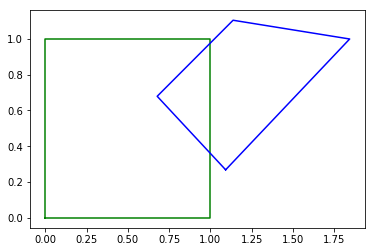

In [1]:
%matplotlib inline
from utils import imgshow, imgshow2, extract_matches
import numpy as np
import matplotlib.pyplot as plt

img0 = plt.imread("overlap00.png").sum(axis=-1)
img1 = plt.imread("overlap01.png").sum(axis=-1)

X = np.array([[0,0,1],
              [1,0,1],
              [1,1,1],
              [0,1,1],
              [0,0,1]])

H = np.random.rand(3,3)
#H/= H[2,2]

Xprime = (H @ X.T).T
Xprime/=Xprime[:,2][:,np.newaxis]

plt.plot(X[:,0],X[:,1],'g-')
plt.plot(Xprime[:,0],Xprime[:,1],'b-')
plt.show()

How do we solve for this thing given our point correspondences?  We need an equation for the eight unknowns in the matrix $H$.  By doing some algebra, we find that we can generate a linear system of equations for the coefficients of $H$:
$$
A \vec{h} = 0,
$$
where
$$
\vec{h} = \begin{bmatrix} h_{11}, h_{12}, \ldots, h_{32}, h_{33} \end{bmatrix}
$$
and 
$$
A = \begin{bmatrix}  0 & 0 & 0 & -u_1 & -v_1 & -1 & v_1' u_1 & v'_1 v_1& v'_1 \\
                     u_1 & v_1 & 1 &  0   & 0    &  0 & -u'_1 u_1 & -u'_1 v_1 & -u'_1 \\
                     \vdots & \ddots & & & & & & & \vdots \\
                     0 & 0 & 0 & -u_n & -v_n & -1 & v_n' u_n & v'_n v_n& v'_n \\
                     u_n & v_n & 1 &  0   & 0    &  0 & -u'_n u_n & -u'_n v_n & -u'_n \end{bmatrix}
$$                     

Note that for this matrix problem to be well-posed, $n$ (the number of correspondences) must equal 4.  Even still, this system is singular: this is because $h$ is only really defined up to a constant.  Thus, the entries of $h$ are in the nullspace of $A$.  Fortunately, finding this nullspace is easy: take the singular value decomposition of $A$, i.e.
$$
SVD(A) = U \Sigma V^T.
$$
If the singular values (the entries in $\Sigma$) are in descending order (as they usually are), then the nullspace of $A$ is given by the corresponding vector in $V$, or the bottom row in $V^T$.  

As it turns out this SVD-based method for finding the nullspace is also applicable when $n>4$, e.g. we have more correspondences than the requisite 4.  In the case of this overdetermined system, there won'd be a nullspace, but the optimal solution for the homography matrix is still given by the column in $V$ that corresponds to the smallest singular valuem, and there is no change to the routine (except that $A$ has more rows). 

**Your assignment is to generate code that takes a set of point correspondences $\{(u_i,v_i, u'_i,v'_i)\}$ for $i$ in $n$, and solves for the homography matrix between them.  You can directly apply this to the matches that you've found via your stitching code so far, but you will find that this procedure is extremely sensitive to outliers.  To determine if your code is working properly, use the synthetic correspondences generated in the homography demo above to recover the matrix $H$ from $X$ and $X'$.**

In [2]:
def solve_for_homography(x,xp):
    if x.shape != xp.shape:
        raise ValueError("X and X_Prime must have matching shapes")
    if x.shape[0] < 4:
        raise ValueError("Not enough points")
    n = x.shape[0]
    A = np.zeros((n*2, 9))
    for i, (uv, uvp) in enumerate(zip(x,xp)):
        u, v = uv[:2]
        up, vp = uvp[:2]
        A[2*i, :] = [0,0,0, -u, -v, -1, vp*u, vp*v, vp]
        A[2*i+1, :] = [u, v, 1, 0, 0, 0, -up*u, -up*v, -up]
        
    U,Sigma,Vt = np.linalg.svd(A)
    
    h = Vt[-1, :].copy()
    H = h.reshape(3,3)
    return H;

In [3]:
Hsolved = solve_for_homography(X, Xprime)
print(f"H:\n{H}")
print(f"Hsolved:\n{Hsolved}")
print(f"H / Hsolved\n{H/Hsolved}")

H:
[[0.72143759 0.0562209  0.93846356]
 [0.66813933 0.76519903 0.23058175]
 [0.04128855 0.60824356 0.85883468]]
Hsolved:
[[0.38029879 0.0296363  0.49470192]
 [0.35220314 0.40336721 0.12154892]
 [0.02176486 0.32062966 0.45272633]]
H / Hsolved
[[1.89702833 1.89702833 1.89702833]
 [1.89702833 1.89702833 1.89702833]
 [1.89702833 1.89702833 1.89702833]]


## RANSAC
Now you have the methods necessary to produce homographies between images, right?  Well, almost.  As it turns out, the computation of the homography is *highly* sensitive to error, e.g. faulty matches.  The following is the result of my code after running the ratio test:
<img src="filtered_matches.png">
Obviously, most of the matches are correct.  However, a few are incorrect, and those incorrect ones are going to have an outsize influence on the computed homography.  For example, here's the stitch I get from using all the points in the above image:
<img src="bad_homography.png">
We need to come up with some way of eliminating bad matches.  Another way of saying this is that we need to remove matches that are *outliers*: a data point that we believe was generated by a different process than the one we're trying to model.  Because a homography does in fact capture the change in an image under the assumption of pure rotation, a bad match created by our matching routine is exactly an outlier.  

There are quite a few algorithms proposed over the years for identifying and eliminating outliers, but by far the most popular (particularly in computer vision) is called RANdom SAmple Consensus, or RANSAC for short.  As the name implies, it is a randomized algorithm, and does not guarantee the optimal solution.  However, it works very well in practice and is fast.  The idea is as follows: First, take a random subset of data (i.e. a random subset of the matches) of size $n$.  Compute a homography based on these $n$ randomly selected matches, which we'll call $H_{maybe}$.  Now, for the remaining points not used to fit the model, apply $H_{maybe}$ to the point locations in image 1 to predict their position in image 2.
$$
\begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} = H_{maybe} \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}
$$
$$ 
u' = x'/w'
$$
$$
v' = y'/w'
$$



For each point, compute the distance between this predicted point and the data value: 
$$
R_i = \sqrt{(u_i' - u_i)^2 + (v_i' - v_i)^2}.
$$
If $R_i<r$, where $r$ is an outlier threshold (often 3-5 pixels), then the point is considered an inlier.  Otherwise it is an outlier.  Combine these inliers with the points used to compute the initial homography.  If the number of inliers is greater than any previous iteration, recompute $H$.  The best $H$ will be that for which the number of inliers is maximized.  This is more easily understood in pseudocode:

In [4]:
def split_data(x, y, n):
        ridx = np.random.permutation(len(x))
        training = ridx[:n]
        test = ridx[n:]
        xs = x[training]
        ys = y[training]
        xr = x[test]
        yr = y[test]
        
        return xs, ys, xr, yr, ridx
    
def RANSAC(number_of_iterations, matchesX, matchesXP, n, r, d):
    if n > len(matchesX):
        raise ValueError("Subsample size is greater than length of data")
    H_best = np.array([[1,0,0],[0,1,0],[0,0,1]])
    X_inliers = []
    XP_inliers = []
    inlier_best = -1
    for i in range(number_of_iterations):
        # 1. Select a random sample of length n from the matches
        xs, xps, xr, xpr, ridx = split_data(matchesX, matchesXP, n)
        
        # 2. Compute a homography based on these points using the methods given above
        H_Maybe = solve_for_homography(xs,xps)
        
        # 3. Apply this homography to the remaining points that were not randomly selected
        xp_pred = (H_Maybe @ xr.T).T
        xp_pred /= xp_pred[:,2][:,np.newaxis]
        
        # 4. Compute the residual between observed and predicted feature locations
        R = np.sqrt(((xp_pred-xpr)**2).sum(axis=-1))
        
        # 5. Flag predictions that lie within a predefined distance r from observations as inliers
        inlier_cond = (R <= r)
        ninliers = inlier_cond.sum()
        
        # 6. If number of inliers is greater than the previous best
        #    and greater than a minimum number of inliers d,
        if (ninliers > inlier_best) and (ninliers >= d):
            
            #    7. update H_best
            H_best = H_Maybe
            
            #    8. update list_of_inliers
            inliers_ridx = ridx[n:][inlier_cond]
            X_inliers = matchesX[inliers_ridx]
            XP_inliers = matchesXP[inliers_ridx]
            inlier_best = ninliers;
        
    if inlier_best <= 0:
        raise Exception("Could not find enough inliers")
            
    return H_best, X_inliers, XP_inliers

In [5]:
x, xp = extract_matches(img0, img1)

In [11]:
X = np.array([(xi[0], xi[1], 1) for xi in x])
XP = np.array([(xi[0], xi[1], 1) for xi in xp])

H_best, X_inliers, XP_inliers = RANSAC(10000, X, XP, 4, 5, 10)

Note that the wikipedia page for RANSAC also has an excellent pseudocode description: https://en.wikipedia.org/wiki/Random_sample_consensus

**Implement RANSAC for the problem of matching keypoints, and apply it to your images.  Write a function which returns a robust estimate of the homography matrix between the two images**

## Warping
With a homography matrix in hand, we can warp image 2 into the coordinate system of image 1.  A do-it-yourself implementation of this process takes a bit of doing.  In particular, it requires that we create an interpolant of image 2 in its original coordinate system, then for each point in image_1's coordinate system, we apply the inverse of the homography and sample from that location.  While not terribly difficult to implement in practice, we will instead simply use a built-in function from scikit-image:

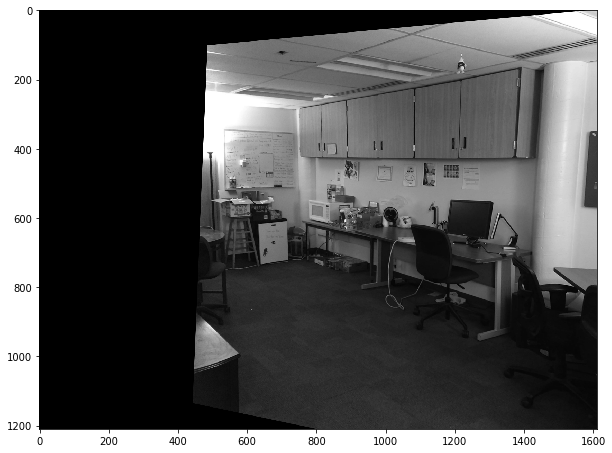

In [16]:
import skimage.transform as skt
#H_best = np.eye(3) # CHANGE ME!

# Create a projective transform based on the homography matrix $H$
proj_trans = skt.ProjectiveTransform(H_best)

# Warp the image into image 1's coordinate system
image_2_transformed = skt.warp(img1,proj_trans)
imgshow(image_2_transformed)

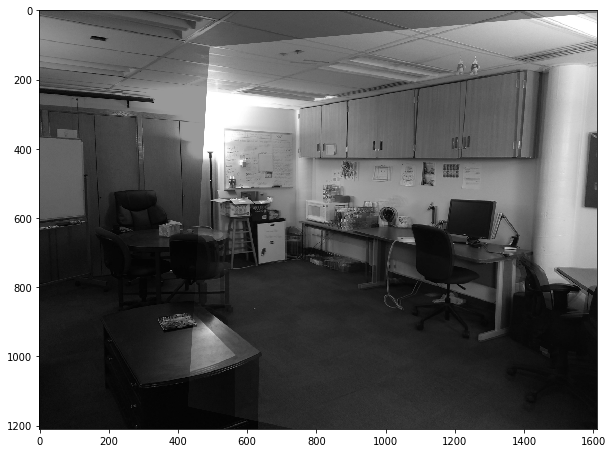

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(img0, cmap="gray")
plt.imshow(image_2_transformed, alpha=0.4, cmap="gray")
plt.show()